# Sandbox/demo to go along with the MD assignment and lectures

## PharmSci 175/275
Author: David Mobley




## Preparation 

To use this notebook you will either need to run it locally using Jupyter or on Google Colab. To run this notebook you will need the OpenEye toolkits installed, as well as the OpenFF toolkits (`openff-toolkit`), `openmm`, and other libraries. If you installed these in a local environment during prep for the class, you should already be prepared; if you are using Google Colab, you will need to install them here. 

### Preparation for Google Colab (NOT FOR LOCAL USE)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MobleyLab/drug-computing/blob/master/uci-pharmsci/lectures/MD/MD_Sandbox_Molecule.ipynb)

For Google Colab, we'll use `conda` for installation because it will work better with packaging for OpenFF and OpenMM.  Begin by unsetting the PYTHONPATH to prevent issues with miniconda, then installing miniconda (which will take perhaps 20 seconds to a couple of minutes):

In [ ]:
%env PYTHONPATH=
! wget https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
! chmod +x Miniconda3-py37_4.10.3-Linux-x86_64.sh
! bash ./Miniconda3-py37_4.10.3-Linux-x86_64.sh -b -f -p /usr/local
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

env: PYTHONPATH=
--2021-12-30 00:01:36--  https://repo.anaconda.com/miniconda/Miniconda3-py37_4.10.3-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.130.3, 104.16.131.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.130.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 89026327 (85M) [application/x-sh]
Saving to: ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’

Miniconda3-py37_4.1 100%[===================>]  84.90M   238MB/s    in 0.4s    

2021-12-30 00:01:36 (238 MB/s) - ‘Miniconda3-py37_4.10.3-Linux-x86_64.sh’ saved [89026327/89026327]

PREFIX=/usr/local
Unpacking payload ...
Solving environment: - \ | / - \ done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - _libgcc_mutex==0.1=main
    - _openmp_mutex==4.5=1_gnu
    - brotlipy==0.7.0=py37h27cfd23_1003
    - ca-certificates==2021.7.5=h06a4308_1
    - certifi==2021.5.30=py37h06a4308_0
    - cffi==1.

Once that is done, install the OpenEye toolkits:

In [ ]:
!conda install -c openeye openeye-toolkits --yes

Solving environment: | / - \ | / - done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openeye-toolkits


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    attrs-21.2.0               |     pyhd3eb1b0_0          46 KB
    ca-certificates-2021.10.26 |       h06a4308_2         115 KB
    certifi-2021.10.8          |   py37h06a4308_0         151 KB
    conda-4.11.0               |   py37h06a4308_0        14.4 MB
    importlib-metadata-4.8.2   |   py37h06a4308_0          39 KB
    importlib_metadata-4.8.2   |       hd3eb1b0_0          12 KB
    iniconfig-1.1.1            |     pyhd3eb1b0_0           8 KB
    openeye-toolkits-2021.2.0  |           py37_0        79.6 MB  openeye
    openssl-1.1.1l             |       h7f8727e_0         2.5 MB
    packaging-21.3             |     pyhd3eb1b0_0          36 KB
    pluggy-1.0.0               |   p

Next, mount your Google Drive, which you will need at least for your OpenEye license:

In [ ]:
# Run cell if using collab

# Mount google drive to Colab Notebooks to access files
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


Prep OpenEye license and check: 

In [ ]:
license_filename = '/content/drive/MyDrive/oe_license.txt'
import openeye

import os
if os.path.isfile(license_filename):
  license_file = open(license_filename, 'r')
  openeye.OEAddLicenseData(license_file.read())
  license_file.close()
else:
  print("Error: Your OpenEye license is not readable; please check your filename and that you have mounted your Google Drive")

licensed = openeye.oechem.OEChemIsLicensed()
print("Was your OpenEye license correctly installed (True/False)? " + str(licensed))
if not licensed:
  print("Error: Your OpenEye license is not correctly installed.")
  raise Exception("Error: Your OpenEye license is not correctly installed.")

Was your OpenEye license correctly installed (True/False)? True


#### Now(for Colab) we conda install the other prerequisites

In [ ]:
!conda install -c conda-forge openff-toolkit openmm --yes

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - openff-toolkit
    - openmm


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    _libgcc_mutex-0.1          |      conda_forge           3 KB  conda-forge
    _openmp_mutex-4.5          |            1_gnu          22 KB  conda-forge
    ambertools-21.11        

### Preparation for local use

For local use, you need to ensure you are operating in a Python environment with the OpenEye toolkits (and license), the `openff-toolkit`, and `openmm`, the latter two of which are available from conda-forge.

# Now let's do MD on a molecule!

In the other sandbox associated with this lecture, we did some very simple MD on a 1D Lennard-Jones system. Now let's head towards the opposite extreme and do our first molecular system.

Here, we'll draw on OpenMM, a molecular mechanics toolkit we'll see again later in the class, for running some simple energy minimizations and molecular dynamics. And we'll use the `openforcefield` tools for assigning a force field for a molecule, because they make this very simple (and you have them already installed).

## First, we generate a molecule

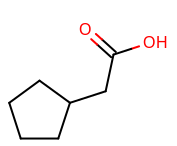

In [ ]:
#@title
# What SMILES string for the guest? Should be isomeric SMILES
mol_smiles = 'OC(CC1CCCC1)=O'

# Import stuff
from openeye.oechem import *
from openeye.oeomega import * # conformer generation
from openeye.oequacpac import * #for partial charge assignment

# Create empty OEMol
mol = OEMol()
# Convert SMILES
OESmilesToMol(mol, mol_smiles)

# Draw to make sure that's what we want
from IPython.display import Image
import openeye.oedepict as oedepict # Use OpenEye depiction toolkit
oedepict.OEPrepareDepiction(mol)
oedepict.OERenderMolecule("DepictMolSimple.png", mol)
Image('DepictMolSimple.png',width = 200)

## For some use cases, we would begin with a structure of our molecule

We're about to jump into the OpenFF toolkit and prep our molecule for simulation. We could either begin with the molecule in a format which had coordinates (like .mol2 or .sdf) if we were starting from a conformer we wanted to use, or we could let the toolkit generate a conformer for us. Here, since we aren't starting with a conformer we want to use, we will let the toolkit generate an initial conformer. 

## We apply a force field to assign parameters to the system

This uses the `openff-toolkit` from Open Force Field, along with the `openff-2.0.0` Parsley force field.

In [ ]:
from openff.toolkit.topology import Topology, Molecule
from openff.toolkit.typing.engines.smirnoff import ForceField

# Get force field ready
ff = ForceField('openff-2.0.0.offxml')

# Generate an OpenFF molecule from the SMILES
offmol = Molecule.from_smiles(mol_smiles)

# Draw the OpenFF molecule to make sure it looks OK
offmol.visualize()

# Create an empty OpenFF Topology 
topology = Topology()

# Add our molecule to the Topology (a Topology can contain multiple molecules)
molecule_topology_indices = topology.add_molecule(offmol)

# Parametrize the topology and create an OpenMM System.
system = forcefield.create_openmm_system(off_topology)


ImportError: ignored

## Next we'll start off by doing an energy minimization

We first prepare the system, but then the actual energy minimization is very simple. I believe OpenMM is using an L-BFGS minimizer.

In [ ]:
# Even though we're just going to minimize, we still have to set up an integrator, since a Simulation needs one
integrator = openmm.VerletIntegrator(2.0*unit.femtoseconds)
# Prep the Simulation using the parameterized system, the integrator, and the topology
simulation = app.Simulation(topology, system, integrator)
# Copy in the positions
simulation.context.setPositions( positions) 

# Get initial state and energy; print
state = simulation.context.getState(getEnergy = True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy before minimization (kcal/mol): %.2g" % energy)

# Minimize, get final state and energy and print
simulation.minimizeEnergy()
state = simulation.context.getState(getEnergy=True, getPositions=True)
energy = state.getPotentialEnergy() / unit.kilocalories_per_mole
print("Energy after minimization (kcal/mol): %.2g" % energy)
newpositions = state.getPositions()

## Now we do some bookkeeping to run MD

Most of this is just setup, file bookkeeping, temperature selection, etc. The key part which actually runs it is the second-to-last block of code which says `simulation.step(1000)` which runs 1000 steps of dynamics. The timestep for this is set near the top, and is 2 femtoseconds per timestep, so the total time is 2000 fs, or 2 ps.

Simulation snapshots are stored to a NetCDF file for later visualization, every 100 frames (so we'll end up with 10 of them). You can adjust these settings if you like.

In [ ]:
# Set up NetCDF reporter for storing trajectory; prep for Langevin dynamics
from mdtraj.reporters import NetCDFReporter
integrator = openmm.LangevinIntegrator(300*unit.kelvin, 1./unit.picosecond, 2.*unit.femtoseconds)

# Prep Simulation
simulation = app.Simulation(topology, system, integrator)
# Copy in minimized positions
simulation.context.setPositions(newpositions)

# Initialize velocities to correct temperature
simulation.context.setVelocitiesToTemperature(300*unit.kelvin)
# Set up to write trajectory file to NetCDF file in data directory every 100 frames
netcdf_reporter = NetCDFReporter(os.path.join('.', 'trajectory.nc'), 100) #Store every 100 frames
# Initialize reporters, including a CSV file to store certain stats every 100 frames
simulation.reporters.append(netcdf_reporter)
simulation.reporters.append(app.StateDataReporter(os.path.join('.', 'data.csv'), 100, step=True, potentialEnergy=True, temperature=True, density=True))

# Run the simulation and print start info; store timing
print("Starting simulation")
start = time.clock()
simulation.step(1000) #1000 steps of dynamics
end = time.clock()

# Print elapsed time info, finalize trajectory file
print("Elapsed time %.2f seconds" % (end-start))
netcdf_reporter.close()
print("Done!")

## Now we can visualize the results with `nglview`

If you don't have `nglview`, you can also load the PDB file, `mymolecule.pdb`, with a standard viewer like VMD or Chimera, and then load the NetCDF trajectory file (`trajectory.nc`) in afterwards.

In [ ]:
# Load stored trajectory using MDTraj; the trajectory doesn't contain chemistry info so we also load a PDB
import mdtraj
import nglview
traj= mdtraj.load(os.path.join('.', 'trajectory.nc'), top=os.path.join('.', 'mymolecule.pdb'))

# View the trajectory
view = nglview.show_mdtraj(traj)
view

## Exercises

- Try your own molecule. What about one which has the potential for internal hydrogen bonding?
- Run the dynamics longer
- What is different if you lower the temperature? Raise the temperature? 